In [1]:
# necessary libraries.
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import time
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

# qiskit functions.

from qiskit import QuantumCircuit
from qiskit import Aer, execute
from qiskit.visualization import plot_histogram

seeds = 15
simu = 'aer_simulator_statevector'

In [2]:
# creates a list of bit strings of length n.
def bin_list(n):
    ans = ['0','1']
    for i in range(n-1):
        P1 = ['0' + ans[j] for j in range(0,2**(i+1))]
        P2 = ['1' + ans[j] for j in range(0,2**(i+1))]
        ans = P1 + P2
    return ans

In [3]:
# minimum vertex cover cost function
def minvertex(x, G):
    x = np.array(list(x), dtype=int)
    term = 0
    for u, v in G.edges():
        term += (1 - x[u])*(1 - x[v])
    return - len(G.edges()) - len(G.nodes()) + term*2 + sum(x)

In [4]:
# computes expectation value.
def expectation(counts, G):
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        obj = minvertex(bitstring, G)
        avg += obj * count
        sum_count += count
    return avg/sum_count

In [5]:
# basic QAOA function which returns counts.
def qaoa(G, theta) :

    # basic QAOA circuit.
    def qaoa_circ(G, theta):
    
        # division of input array Theta.
        nqubits = len(G.nodes())
        nlayers = len(theta)//2 
        beta = theta[:nlayers]
        gamma = theta[nlayers:]

        qc = QuantumCircuit(nqubits)

        # initial state.
        qc.h(range(nqubits))

        for layer in range(nlayers):
        
            # problem unitary.
            for pair in list(G.edges()):
                qc.rzz(2 * gamma[layer], pair[0], pair[1])
            for qubit in range(nqubits):
                qc.rz(2 * gamma[layer], qubit)
            qc.barrier()
            
            # mixer unitary.
            for qubit in range(nqubits):
                qc.rx(2 * beta[layer], qubit)

        qc.measure_all()
        return qc

    def get_expect_qaoa(G, shots=4096):
        backend = Aer.get_backend(simu)
        backend.shots = shots
        def execute_circ(theta):
            qc = qaoa_circ(G, theta)
            counts = backend.run(qc, seed_simulator=seeds, nshots=4096).result().get_counts()
            return expectation(counts, G)
        return execute_circ
    
    global qc_basic
    qc_basic = qaoa_circ(G, theta)
    
    # optimizing parameters for basic QAOA
    expect = get_expect_qaoa(G)
    global res_basic
    res_basic = minimize(expect, theta, method='COBYLA')

    
    backend = Aer.get_backend(simu)
    backend.shots = 4096

    qc_res = qaoa_circ(G, res_basic.x)
    counts = backend.run(qc_res, seed_simulator=seeds).result().get_counts()
    return counts

In [6]:
# multi-angle QAOA function which returns counts.
def maqaoa(G, theta) :
    
    # multi-angle QAOA circuit.
    def maqaoa_circ(G, theta):
    
        nqubits = len(G.nodes()) 
        qc = QuantumCircuit(nqubits)
        
        clauses = len(G.edges())
        nlayers = len(theta)//(2*nqubits+clauses)
        beta = np.reshape(theta[:nlayers*nqubits], (nlayers,nqubits))
        gamma = np.reshape(theta[nlayers*nqubits:], (nlayers,clauses+nqubits))
    
        qc.h(range(nqubits))
    
        for layer in range(nlayers):
            k=0
    
            # problem unitary.
            for pair in list(G.edges()):
                qc.rzz(2 * gamma[layer, k], pair[0], pair[1])
                k+=1
            for qubit in range(nqubits):
                qc.rz(2 * gamma[layer, k], qubit)
                k+=1
            
            # mixer unitary
            for i in range(nqubits):
                qc.rx(2 * beta[layer,i], i)
        
        qc.measure_all()
        return qc

    def get_expect_maqaoa(G, shots=4096):
        backend = Aer.get_backend(simu)
        backend.shots = shots
        def execute_circ(theta):
            qc = maqaoa_circ(G, theta)
            counts = backend.run(qc, seed_simulator=seeds, nshots=4096).result().get_counts()
            return expectation(counts, G)
    
        return execute_circ
    
    global qc_multi
    qc_multi = maqaoa_circ(G, theta)
    
    # optimizing parameters for multi-angle qaoa
    expect = get_expect_maqaoa(G)
    global res_multi
    res_multi = minimize(expect, theta, method='COBYLA')

    backend = Aer.get_backend(simu)
    backend.shots = 4096

    qc_res = maqaoa_circ(G, res_multi.x)
    counts = backend.run(qc_res, seed_simulator=seeds).result().get_counts()
    return counts

Number of Nodes =  9
Number of Edges =  16


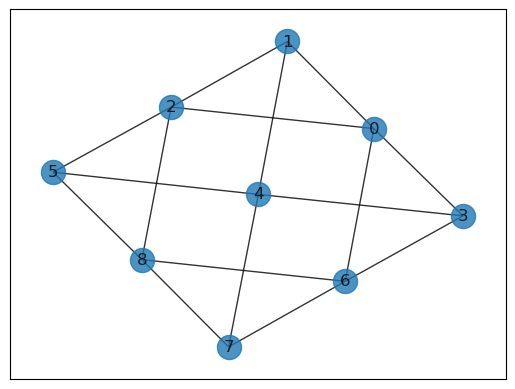

In [7]:
# generating a graph.
import networkx as nx

edges = [(0,1),(1,2),(3,4),(4,5),(6,7),(7,8),(0,3),(3,6),(1,4),(4,7),(2,5),(5,8),(0,6),(6,8),(8,2),(2,0)]
G = nx.Graph(edges)
num_nodes = len(G.nodes())
num_edges = len(G.edges())

print("Number of Nodes = ", num_nodes)
print("Number of Edges = ", num_edges)
nx.draw_networkx(G, with_labels=True, alpha=0.8)

In [8]:
# getting the exact solutions by brute force.
def exactsolns(num_nodes, G):
    binaries = bin_list(num_nodes)
    values = []
    for bit in binaries:
        values.append(minvertex(bit,G))
    soln = min(values)

    soln_bits = []
    for bit in binaries:
        if minvertex(bit,G) == soln:
            soln_bits.append(bit)
    return soln, soln_bits

soln, soln_bits = exactsolns(num_nodes, G)
print('Minimum value of the cost function :', soln)
print('The solution bit strings :', soln_bits)

Minimum value of the cost function : -20
The solution bit strings : ['101010101']


In [9]:
# adding parameters.

# basic QAOA
layers_b = 6
beta = np.random.rand(layers_b)
gamma = np.random.rand(layers_b)
basic = np.concatenate((beta, gamma))

# multi-angle QAOA
layers_ma = 2
beta  = np.array([ np.random.rand(num_nodes) for i in range(layers_ma)])
gamma = np.array([ np.random.rand(num_edges+num_nodes) for i in range(layers_ma)])
theta_multi = np.concatenate((beta.flatten(), gamma.flatten()))*100

Basic QAOA :  -15.30859375


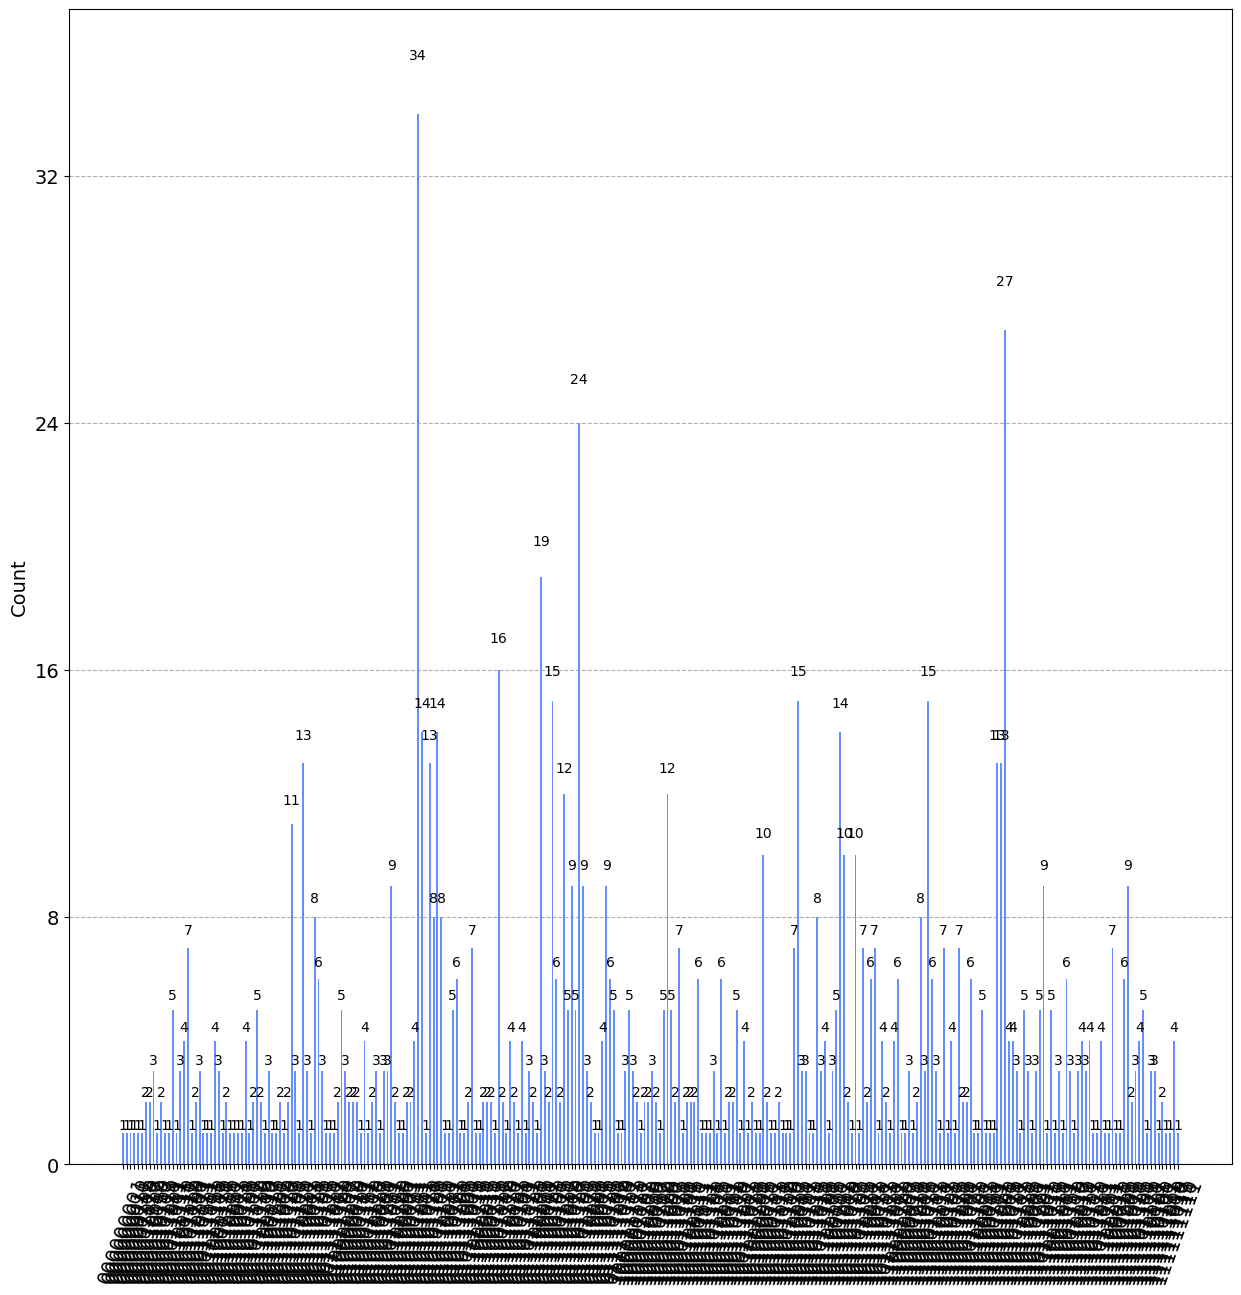

In [10]:
# visualizing the probability distribution - basic QAOA
start = time.time()
counts = qaoa(G, basic)
end = time.time()
time_b = end - start
print("Basic QAOA : ", res_basic.fun)
plot_histogram(counts, figsize = (15,15))

Multi-Angle QAOA :  -19.16015625


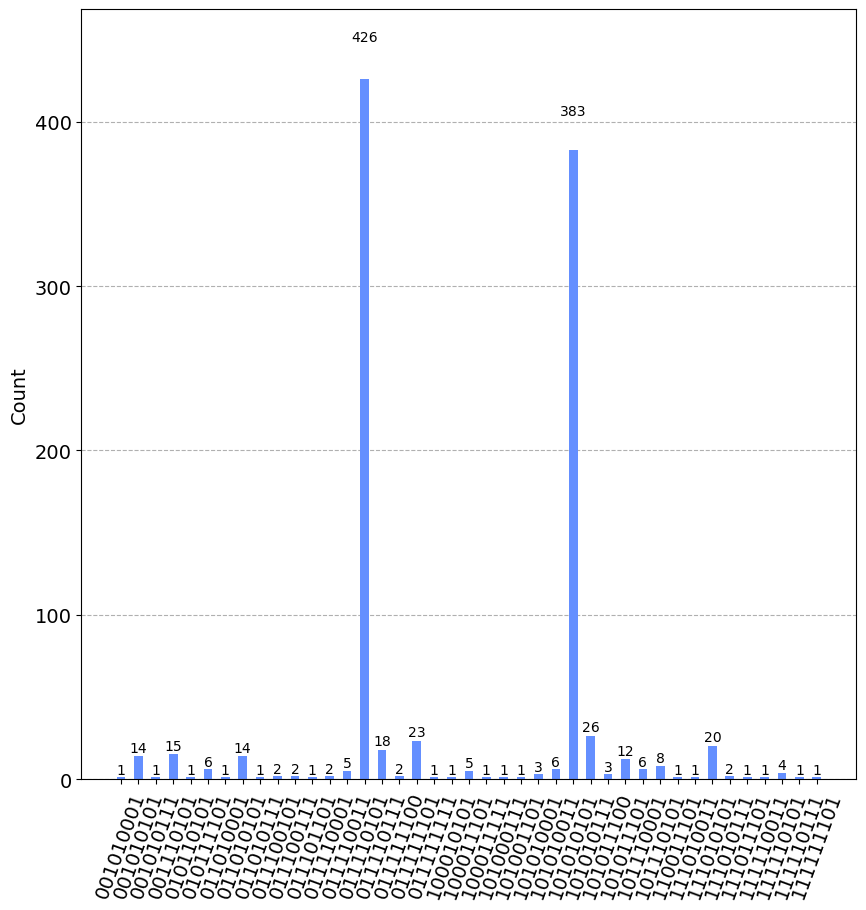

In [11]:
# Visualizing the Probability Distribution - Multi QAOA
start = time.time()
counts_multi = maqaoa(G, theta_multi)
end = time.time()
time_ma = end - start
print("Multi-Angle QAOA : ", res_multi.fun)
plot_histogram(counts_multi, figsize = (10,10))

In [12]:
# approximation ratios
print('For a single run.')
print('Approximation accuracy of simple QAOA      ', '[with',layers_b,'layers] :', (res_basic.fun/soln).round(4), '| Time taken :', np.array(time_b).round(3))
print('Approximation accuracy of multi-angle QAOA ', '[with',layers_ma,'layers] :', (res_multi.fun/soln).round(4), '| Time taken :', np.array(time_ma).round(3))

For a single run.
Approximation accuracy of simple QAOA       [with 6 layers] : 0.7654 | Time taken : 3.03
Approximation accuracy of multi-angle QAOA  [with 2 layers] : 0.958 | Time taken : 8.719


In [20]:
num_iterations = 10
v_arb = []
v_arma = []
v_tb = []
v_tma = []
for i in tqdm(range(num_iterations), desc='Runs'):

    # basic QAOA
    layers_b = 5
    beta = np.random.rand(layers_b)
    gamma = np.random.rand(layers_b) 
    basic = np.concatenate((beta, gamma))*1000

    # multi-angle QAOA
    layers_ma = 2
    beta  = np.array([ np.random.rand(num_nodes) for i in range(layers_ma)])
    gamma = np.array([ np.random.rand(num_edges+num_nodes) for i in range(layers_ma)])
    theta_multi = np.concatenate((beta.flatten(), gamma.flatten()))*1000

    start = time.time()
    counts = qaoa(G, basic)
    end = time.time()
    time_b = end - start

    start = time.time()
    counts_multi = maqaoa(G, theta_multi)
    end = time.time()
    time_ma = end - start

    v_tb.append(time_b)
    v_tma.append(time_ma)
    v_arb.append(res_basic.fun/soln)
    v_arma.append(res_multi.fun/soln)

Runs: 100%|████████████████████████████████████████████████████████████████████████████| 10/10 [03:09<00:00, 18.95s/it]


In [21]:
print('Over', num_iterations, 'runs.')
# approximation ratios
print('Approximation accuracy of simple QAOA      ', '[with',layers_b,'layers] :', sum(np.array(v_arb))/num_iterations, '| Time taken :', sum(np.array(v_tb))/num_iterations)
print('Approximation accuracy of multi-angle QAOA ', '[with',layers_ma,'layers] :', sum(np.array(v_arma))/num_iterations, '| Time taken :', sum(np.array(v_tma))/num_iterations)

Over 10 runs.
Approximation accuracy of simple QAOA       [with 5 layers] : 0.858369140625 | Time taken : 3.186228537559509
Approximation accuracy of multi-angle QAOA  [with 2 layers] : 0.9063281250000002 | Time taken : 15.763312411308288
